# pPXF v6.7.15 Simple Fitting

Simple fitting notebook for getting velocity and sigma. This notebook assumes you're using MILES templates

In [1]:
from os.path import dirname
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

import ppxf as ppxf
import ppxf.ppxf_util as util
import ppxf.miles_util as miles_util

### Input Parameters

Edit all params to suit your input file. 

In [2]:

fittable_file = '/home/daniel/Documents/Swinburne/ultra-diffuse-galaxies/results_GC/M31_B336/obj1/mean.fits'
out_dir = dirname(fittable_file) + '/'
miles_dir = '/home/daniel/Documents/Swinburne/ultra-diffuse-galaxies/source_data/MILES_BASTI_KU_baseFe/'
write_out = False

zi = -0.001983 # redshift guess
FWHM_data = 5070 / 9000 # data resolution
vel_start = -595 # starting velocity guess (km/s).
sigma_start = 7 # starting velocity dispersion guess (km/s).
mask_l = 4900 # wavelength lower limit (Angstrom)
mask_h = 5300 # wavelength upper limit (Angstrom)
region = "all" # define a region to fit (default/all/no_mgb/blue/red/before_mgb/lt5100)
degree = 15 # degree of additive polynomial
mdegree = 15 # degree of multiplicative polynomial

### pPXF Setup

no need to edit (unless you really want to), just run

In [3]:
# All spectra use these
c = 299792.458  # Speed of light in kms-1
FWHM_tem = 2.5  # spectral resolution of MILES (change if using degraded models)

# Extract the wavelength range
hdu = fits.open(fittable_file)
data = hdu[0].data
header = hdu[0].header
wave = header['CRVAL1'] + (np.arange(0., (header['NAXIS1'])) - 1) * header['CDELT1']
mask = (wave > mask_l) & (wave < mask_h)
wave = wave[mask]

# Set up the galaxy
lamRange = np.array([np.min(wave), np.max(wave)])
galaxy, logwave, VelScale = util.log_rebin(lamRange, data[mask])
galaxy = galaxy/np.median(galaxy) # Normalize spectrum to avoid numerical issues
noise = np.full_like(galaxy, 0.01)  # Assume constant noise per pixel here

# Get MILES templates
pathname = miles_dir + '/Mku1.30*baseFe*.fits'  # EMILES Basti_KU_baseFe
miles = miles_util.miles(pathname, VelScale, FWHM_data, FWHM_tem)

wave = np.exp(logwave)
dv = c * (miles.log_lam_temp[0] - np.log(wave[0]))  # km/s
lamRangeTemp = np.exp(np.array([np.min(miles.log_lam_temp), np.max(miles.log_lam_temp)]))

if region == 'all':
    goodPixels = np.arange(0, len(galaxy), 1) # all
elif region == "all_minus_10":
    goodPixels = np.arange(10, len(galaxy)-10, 1) # all
elif region == 'default':
    goodPixels = util.determine_goodpixels(logwave, lamRangeTemp, zi)
elif region == 'no_mgb':
    goodPixels = np.hstack((np.arange(0, 1430, 1), np.arange(1550, len(galaxy), 1)))
elif region == 'blue':
    goodPixels = np.arange(0, round(len(galaxy)/2), 1)
elif region == 'red':
    goodPixels = np.arange(round(len(galaxy)/2), len(galaxy)-25, 1)
elif region == 'before_mgb':
    goodPixels = np.arange(0, 1410, 1)
elif region == 'no_starting_hbeta':
    goodPixels = np.arange(175, len(galaxy), 1)
elif region == 'leo':
    goodPixels = np.arange(150, len(galaxy), 1)
elif region == 'lt5100':
    goodPixels = np.arange(0, 1128, 1)
elif region == 'lt5100-leo':
    goodPixels = np.arange(0, 1103, 1)
else:
    raise Exception("Jonah you numpty define a fitting region!")

/home/daniel/anaconda3/envs/astroconda/lib/python3.7/site-packages/ppxf/miles_util.py:169: RuntimeWarning: invalid value encountered in sqrt
  FWHM_dif = np.sqrt(FWHM_gal**2 - FWHM_tem**2)


### pPXF Fit

Best Fit:       Vel     sigma
 comp. 0:      -598        10
chi2/DOF: 5.002e+05
method = capfit; Jac calls: 12; Func calls: 223; Status: 2
Nonzero Templates: 2 / 636
Formal errors:
     dV    dsigma   dh3      dh4
     3.4     5.3
Best-fitting redshift z = -0.001991 +/- 0.000011
Signal-to-noise ratio per pixel: 43.74


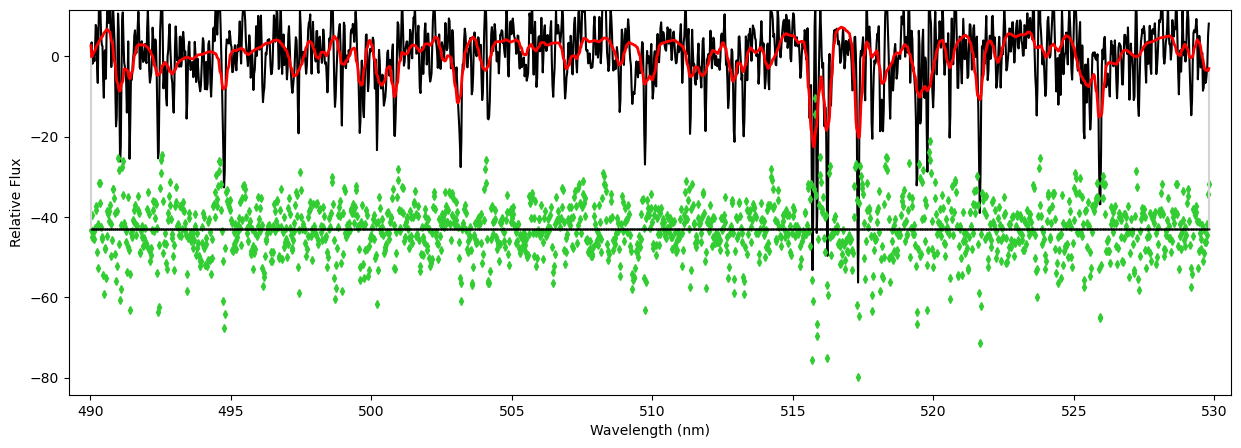

In [4]:
plt.figure(figsize=(15, 5))

pp = ppxf.ppxf.ppxf(
    miles.templates, 
    galaxy, 
    noise, 
    VelScale, 
    start=[vel_start, sigma_start], 
    goodpixels=goodPixels,
    plot=True, 
    moments=2, 
    degree=degree, 
    mdegree=mdegree, 
    lam=wave,
    vsyst=dv,
    component=np.zeros_like(len(miles.templates))
    )

residuals = galaxy[:len(goodPixels)] - pp.bestfit[:len(goodPixels)]
signal = np.median((pp.bestfit[:len(goodPixels)] - pp.apoly[:len(goodPixels)]))#/pp1.mpoly)
noise2 = np.std(residuals[residuals<np.percentile(residuals, 90)])

SN_ratio = signal / noise2

# The updated best-fitting redshift is given by the following
# lines (using equations 5 of Cappellari 2022, arXiv, C22)
errors = pp.error*np.sqrt(pp.chi2)  # Assume the fit is good chi2/DOF=1
redshift_0 = 0
redshift_fit = (1 + redshift_0)*np.exp(pp.sol[0]/c) - 1  # eq. (5c) C22
redshift_err = (1 + redshift_fit)*errors[0]/c            # eq. (5d) C22

print("Formal errors:")
print("     dV    dsigma   dh3      dh4")
print("".join("%8.2g" % f for f in errors))
prec = int(1 - np.floor(np.log10(redshift_err)))  # two digits of uncertainty
print(f"Best-fitting redshift z = {redshift_fit:#.{prec}f} "
        f"+/- {redshift_err:#.{prec}f}")
print(f"Signal-to-noise ratio per pixel: {SN_ratio:.2f}")

if write_out:
    plt.savefig(out_dir + 'fit.png', dpi=300)
plt.show()

if write_out:
    wavelength = wave
    galaxy = pp.galaxy
    bestfit = pp.bestfit

    writeable = np.column_stack((wavelength, galaxy, bestfit))
    np.savetxt(out_dir + 'spec.txt', writeable, fmt="%s")